<a href="https://colab.research.google.com/github/a-mt/fcc-predict-health-cost/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

## Load libraries

In [2]:
# Import libraries. You may or may not use all of these.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

## Load dataset

In [3]:
!wget "https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv"

--2020-10-15 12:06:25--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘insurance.csv’

insurance.csv           [ <=>                ]  49.09K  --.-KB/s    in 0.04s   

2020-10-15 12:06:25 (1.20 MB/s) - ‘insurance.csv’ saved [50264]



In [4]:
df = pd.read_csv("insurance.csv")
df.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


## Check missing values

In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

## Handle categorical values

In [6]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

### Region

In [7]:
df.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [8]:
df = df.join(pd.get_dummies(df.region, prefix='region')).drop('region', axis=1)
df.head()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.9,0,yes,16884.92,0,0,0,1
1,18,male,33.8,1,no,1725.55,0,0,1,0
2,28,male,33.0,3,no,4449.46,0,0,1,0
3,33,male,22.7,0,no,21984.47,0,1,0,0
4,32,male,28.9,0,no,3866.86,0,1,0,0


### Sex

In [9]:
df.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [10]:
labels = {}

values        = df.sex.astype('category')
labels['sex'] = values.cat.categories
df['sex']     = values.cat.codes

df.head()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,yes,16884.92,0,0,0,1
1,18,1,33.8,1,no,1725.55,0,0,1,0
2,28,1,33.0,3,no,4449.46,0,0,1,0
3,33,1,22.7,0,no,21984.47,0,1,0,0
4,32,1,28.9,0,no,3866.86,0,1,0,0


### Smoker

In [11]:
df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [12]:
values           = df.smoker.astype('category')
labels['smoker'] = values.cat.categories
df['smoker']     = values.cat.codes

df.head()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,1,16884.92,0,0,0,1
1,18,1,33.8,1,0,1725.55,0,0,1,0
2,28,1,33.0,3,0,4449.46,0,0,1,0
3,33,1,22.7,0,0,21984.47,0,1,0,0
4,32,1,28.9,0,0,3866.86,0,1,0,0


In [13]:
labels

{'sex': Index(['female', 'male'], dtype='object'),
 'smoker': Index(['no', 'yes'], dtype='object')}

## Explore data

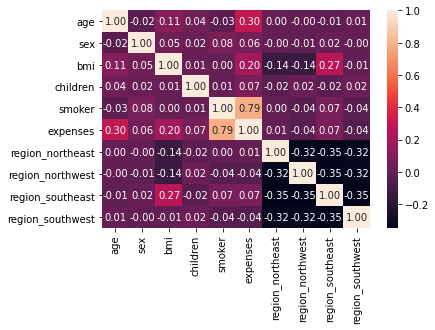

In [14]:
sns.heatmap(df.corr(), annot=True, fmt='.2f')

In [15]:
df.drop(['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest'], axis=1, inplace=True)

In [16]:
df.drop(['sex', 'children'], axis=1, inplace=True)

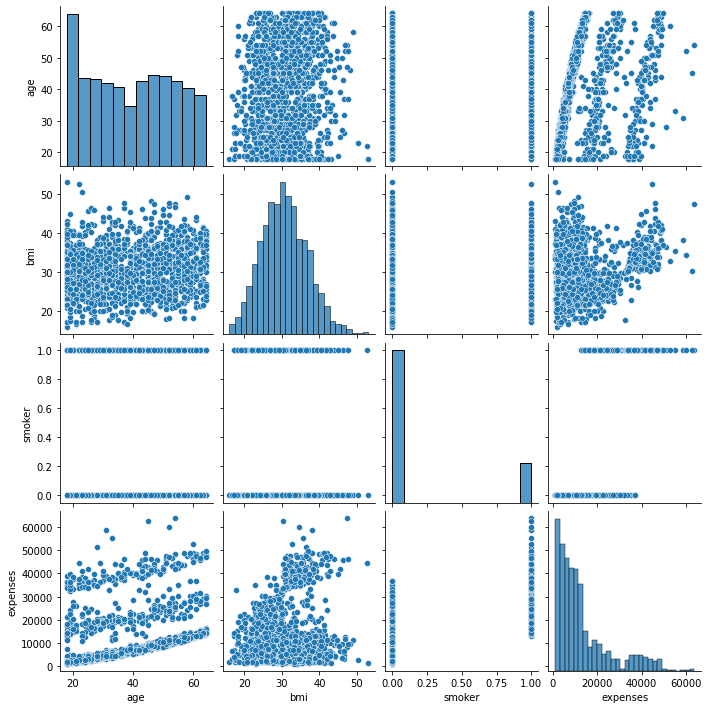

In [17]:
sns.pairplot(df)

## Split data

In [18]:
# shuffle the rows, just in case
df = df.sample(frac=1) 

In [19]:
size          = int(len(df) * .2)
train_dataset = df[:-size]
test_dataset  = df[-size:]

print(len(df), len(train_dataset), len(test_dataset))

1338 1071 267


In [20]:
train_labels  = train_dataset['expenses']
train_dataset = train_dataset.drop('expenses', axis=1)

In [21]:
test_labels   = test_dataset['expenses']
test_dataset  = test_dataset.drop('expenses', axis=1)

## Build model

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(len(train_dataset.keys()),)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(0.05),
    loss='mse',
    metrics=['mae', 'mse']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3)                 12        
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,493
Trainable params: 4,487
Non-trainable params: 6
_________________________________________________________________


In [27]:
# taken from tfdocs.modeling.EpochDots
class EpochDots(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      print()
      print('Epoch: {:d}, '.format(epoch), end='')
      for name, value in sorted(logs.items()):
        print('{}:{:0.4f}'.format(name, value), end=', ')
      print()

    print('.', end='')

In [28]:
r = model.fit(train_dataset, train_labels, epochs=500,
              verbose=0, callbacks=[EpochDots()])


Epoch: 0, loss:24170452.0000,  mae:2915.9453,  mse:24170452.0000,  
....................................................................................................
Epoch: 100, loss:22684380.0000,  mae:2794.4045,  mse:22684380.0000,  
....................................................................................................
Epoch: 200, loss:22628498.0000,  mae:2803.6338,  mse:22628498.0000,  
....................................................................................................
Epoch: 300, loss:24286430.0000,  mae:2896.4360,  mse:24286430.0000,  
....................................................................................................
Epoch: 400, loss:23107222.0000,  mae:2847.3750,  mse:23107222.0000,  
....................................................................................................

In [29]:
res = model.evaluate(test_dataset, test_labels, verbose=2)
print(res)

9/9 - 0s - loss: 22094340.0000 - mae: 2801.9905 - mse: 22094340.0000
[22094340.0, 2801.990478515625, 22094340.0]


## Challenge

9/9 - 0s - loss: 22094340.0000 - mae: 2801.9905 - mse: 22094340.0000
Testing set Mean Abs Error: 2801.99 expenses
You passed the challenge. Great job!


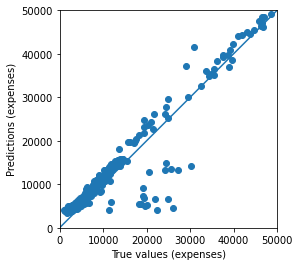

In [30]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
